#Medical Code Prediction MIMIC-III
Robert Sato

Dr. Xin Wang

CSE 244B - Natural Language Processing

Winter 2022

**Plan**
- setup environment
    - setup github for this notebook
    - do not let the data be publicly accessible
- data analysis/preprocessing
    - understand the structure of the data
    - load into a readable/pliable format (pandas)
    - visualize some of the data
    - find the clinical notes
    - find the codes corresponding to the clinical notes (labels)
    - helper functions
        - create dataset (X, y)
            - shuffled randomized w validation split
- load a pretrained model
- read in the text as input
- multi-label classification
    
**Note**
MIMIC-IV note data is not available...
just use MIMIC-III for now

mimic-iii-dia-data was created from CAML-MIMIC github
- https://github.com/jamesmullenbach/caml-mimic
- [Explainable Prediction of Medical Codes from Clinical Text]
    - https://arxiv.org/abs/1802.05695


- data from CAML has much shorter text (they preprocessed) but their labels include words for some reason
- data from ICD prediction MIMIC has longer text but succint label column

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## loading from pickle (ignore and use CAML data)
- from [Predicting Multiple ICD-10 Codes from Brazilian-Portuguese Clinical Notes]
    - https://arxiv.org/pdf/2008.01515.pdf
    - https://github.com/3778/icd-prediction-mimic
- using other data bc already preprocessed (somewhat)

In [3]:
data = pd.read_pickle("/content/gdrive/MyDrive/CSE_244B_W2022/project/mimic3_data.pkl")

In [4]:
data.head()

,HADM_ID,ICD9_CODE,SUBJECT_ID,TEXT
0,100001,"[25013, 3371, 5849, 5780, V5867, 25063, 5363, ...",58526,Admission Date: [**2117-9-11**] ...
1,100003,"[53100, 2851, 07054, 5715, 45621, 53789, 4019,...",54610,Admission Date: [**2150-4-17**] ...
2,100006,"[49320, 51881, 486, 20300, 2761, 7850, 3090, V...",9895,Admission Date: [**2108-4-6**] Discharg...
3,100007,"[56081, 5570, 9973, 486, 4019]",23018,Admission Date: [**2145-3-31**] ...
4,100009,"[41401, 99604, 4142, 25000, 27800, V8535, 4148...",533,Admission Date: [**2162-5-16**] ...


In [5]:
data.describe()

,HADM_ID,SUBJECT_ID
count,52722.000000,52722.000000
mean,149987.468230,35177.283449
std,28910.706251,28570.362362
min,100001.000000,3.000000
25%,124922.250000,12566.000000
50%,150098.500000,25251.000000
75%,175033.250000,57170.500000
max,199999.000000,99999.000000


In [6]:
print('average diagnosis length: ', data.TEXT.str.split().str.len().mean())
print('stdev diagnosis length: ', data.TEXT.str.split().str.len().std())

average diagnosis length:  1551.5281666097644
stdev diagnosis length:  781.001080162633


## Load the Data
- MIMIC-IV note data not available
- TF, use MIMIC-III

Data Needed for Diagnosis Classification
- NOTEEVENTS.csv - actual notes from doctor's diagnoses
- ADMISSIONS.csv - admission info (in time/out time)
- DIAGNOSES_ICD.csv - ICD to predict

In [7]:
#MIMIC_IV_data_path = "/content/gdrive/MyDrive/CSE_244B_W2022/project/mimic-iv-1.0/"
MIMIC_III_data_path = "/content/gdrive/MyDrive/CSE_244B_W2022/project/mimic-iii_dia_data/"

In [8]:
!ls $MIMIC_III_data_path

DIA_PLUS_adm_test.csv  DIA_PLUS_adm_train.csv  DIA_PLUS_adm_val.csv


In [9]:
train = pd.read_csv(MIMIC_III_data_path + 'DIA_PLUS_adm_train.csv')
test = pd.read_csv(MIMIC_III_data_path + 'DIA_PLUS_adm_test.csv')
val = pd.read_csv(MIMIC_III_data_path + 'DIA_PLUS_adm_val.csv')

In [10]:
train.head()

,id,text,labels
0,159643,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: This 60 ...,",276,2765,2767,412,414,4140,424,4241,427,4273,..."
1,147171,CHIEF COMPLAINT: Substernal Chest Pain\n\nPRES...,"410,4101,414,4140,427,4271,4273,428,4280,4282,..."
2,199961,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: The pati...,",250,2506,285,2859,403,4039,707,7070,720,7200,..."
3,136812,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: This is ...,",244,2449,276,2765,280,2800,426,4261,427,4278,..."
4,175700,CHIEF COMPLAINT: s/p rollover MVC with prolong...,"285,2851,327,3272,481,518,5180,799,7990,807,80..."


In [11]:
print('average diagnosis length: ', train.text.str.split().str.len().mean())
print('stdev diagnosis length: ', train.text.str.split().str.len().std())

average diagnosis length:  395.8866270518327
stdev diagnosis length:  235.62215600801855


In [12]:
# get the labels for one training example
labels = train['labels'].iloc[1]
print(labels)

410,4101,414,4140,427,4271,4273,428,4280,4282,458,4582,997,9971,acute,anterior,artery,atherosclerosis,atrial,cardiac,care,classified,complications,congestive,coronary,elsewhere,episode,failure,fibrillation,heart,hypotension,iatrogenic,infarction,initial,myocardial,native,paroxysmal,systolic,tachycardia,unspecified,ventricular,wall


In [13]:
train_1_labels = list(train[train['id']==100001]['labels'])
data_1_labels = list(data[data['HADM_ID']==100001]['ICD9_CODE'])
print(train_1_labels, "\n", data_1_labels)

['250,2501,2504,2505,2506,2508,337,3371,362,3620,403,4039,458,4580,536,5363,578,5780,584,5849,585,5853,707,7078,V135,V1351,V586,V5867,acute,autonomic,background,chronic,classified,current,diabetes,diabetic,disease,disorders,elsewhere,failure,fracture,gastroparesis,hematemesis,history,hypertensive,hypotension,iii,insulin,iv,juvenile,ketoacidosis,kidney,longterm,manifestations,moderate,neurological,neuropathy,ophthalmic,orthostatic,pathologic,peripheral,personal,renal,retinopathy,sites,specified,stage,type,ulcer,uncontrolled,unspecified,use'] 
 [array(['25013', '3371', '5849', '5780', 'V5867', '25063', '5363', '4580',
       '25043', '40390', '5853', '25053', '36201', '25083', '7078',
       'V1351'], dtype=object)]


In [14]:
train[train['id']==100001].head()

,id,text,labels
25218,100001,"CHIEF COMPLAINT: nausea, vomiting\n\nPRESENT I...","250,2501,2504,2505,2506,2508,337,3371,362,3620..."


In [15]:
data[data['HADM_ID']==100001].head()

,HADM_ID,ICD9_CODE,SUBJECT_ID,TEXT
0,100001,"[25013, 3371, 5849, 5780, V5867, 25063, 5363, ...",58526,Admission Date: [**2117-9-11**] ...


## Create vector representations for the texts

### Convert the ICD code lists to a one hot vector

In [16]:
# find all unique codes in the ICD9_CODE column
all_codes = set()
for i, row in data.iterrows():
    codes = row['ICD9_CODE']
    for code in codes:
        all_codes.add(code)
print(all_codes)
code_count = len(all_codes)
print(code_count, "unique codes found")

{'44289', '0542', '45350', '81383', '76408', '74489', '38905', '07052', 'E8768', '74742', '30491', '20218', '7013', '37820', '41404', '8251', '7859', 'E9687', '72743', 'V580', '73316', '27906', '78799', '75265', '4401', '80182', 'V153', '25030', '20963', '5691', '4440', '8488', '28859', 'E8494', '5272', '9894', '2769', '20903', '71589', 'E8793', '7459', '7012', '4370', 'E8532', '30989', '3492', '80420', '4599', '3221', '3510', '53570', '92810', '5523', '36616', '8371', 'V058', '1516', '76070', '77183', '37741', '3577', '25541', '53190', '01896', '64893', '59010', '4843', 'V1204', '9580', '01504', 'E9470', 'V0259', 'V155', 'E8353', '75261', '1401', '36283', '1965', '9040', '36846', '73002', '99939', '45371', '42781', '53370', '20028', 'V444', '7843', '99769', 'V8745', '64252', '34481', '71530', '71593', '2771', 'V5873', '430', '3337', '78451', '0310', '9065', '7299', 'V6441', '6023', '83920', '83301', '6159', 'E9571', '9054', '7862', '85229', '85406', '44589', '56982', 'V5831', '734', '

In [17]:
# create translation dictionaries
index_to_code = {i: code for i, code in enumerate(all_codes)}
print(index_to_code)
code_to_index = {code: i for i, code in enumerate(all_codes)}
print(code_to_index)

{0: '44289', 1: '0542', 2: '45350', 3: '81383', 4: '76408', 5: '74489', 6: '38905', 7: '07052', 8: 'E8768', 9: '74742', 10: '30491', 11: '20218', 12: '7013', 13: '37820', 14: '41404', 15: '8251', 16: '7859', 17: 'E9687', 18: '72743', 19: 'V580', 20: '73316', 21: '27906', 22: '78799', 23: '75265', 24: '4401', 25: '80182', 26: 'V153', 27: '25030', 28: '20963', 29: '5691', 30: '4440', 31: '8488', 32: '28859', 33: 'E8494', 34: '5272', 35: '9894', 36: '2769', 37: '20903', 38: '71589', 39: 'E8793', 40: '7459', 41: '7012', 42: '4370', 43: 'E8532', 44: '30989', 45: '3492', 46: '80420', 47: '4599', 48: '3221', 49: '3510', 50: '53570', 51: '92810', 52: '5523', 53: '36616', 54: '8371', 55: 'V058', 56: '1516', 57: '76070', 58: '77183', 59: '37741', 60: '3577', 61: '25541', 62: '53190', 63: '01896', 64: '64893', 65: '59010', 66: '4843', 67: 'V1204', 68: '9580', 69: '01504', 70: 'E9470', 71: 'V0259', 72: 'V155', 73: 'E8353', 74: '75261', 75: '1401', 76: '36283', 77: '1965', 78: '9040', 79: '36846', 

In [18]:
# helper function to create one hot encoding from a list of indices
def create_one_hot(codes, code_to_index=code_to_index, code_count=code_count):
    ohe = np.zeros(shape=(code_count,), dtype="ubyte") # not sure if i should spec dtype
    for code in codes:
        ohe[code_to_index[code]] = 1
    return ohe

In [19]:
# test ohe create function
d = data['ICD9_CODE'].iloc[0]
ohe = create_one_hot(d)
print("OHE sums to:", np.sum(ohe), "and data has length:", len(d))
print("First code:", d[0], 
      "corresponds to index:", code_to_index[d[0]],
      "\nOHE at that index:", ohe[code_to_index[d[0]]])
print(type(ohe[0]))

OHE sums to: 16 and data has length: 16
First code: 25013 corresponds to index: 3095 
OHE at that index: 1
<class 'numpy.uint8'>


In [20]:
# extract the texts as X and one hot encoding of labels to y
X = [] # diagnosis notes
y = [] # icd codes represented as multi-label OHE
for i, row in data.iterrows():
    codes = row['ICD9_CODE']
    X.append(row['TEXT'])
    y.append(create_one_hot(codes))
print("Length of texts (X):", len(X))
y = np.asarray(y)
print("y shape:", y.shape)

Length of texts (X): 52722
y shape: (52722, 6918)


In [21]:
type(data['TEXT'].iloc[0]) == type(X[0])

True

### Create tokenized inputs
- from above, stored as X (list of str from "TEXT" column of data)

reference: https://www.youtube.com/watch?v=pjtnkCGElcE

In [22]:
!pip install transformers
import transformers

In [24]:
# tokenize
seq_len = 512
num_samples = len(X)

Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

Xids.shape

(52722, 512)

In [25]:
X[0]

"Admission Date:  [**2117-9-11**]              Discharge Date:   [**2117-9-17**]\n\nDate of Birth:  [**2082-3-21**]             Sex:   F\n\nService: MEDICINE\n\nAllergies:\nLevaquin\n\nAttending:[**First Name3 (LF) 2195**]\nChief Complaint:\nnausea, vomiting\n\n\nMajor Surgical or Invasive Procedure:\nnone\n\nHistory of Present Illness:\n35F w/ poorly controlled Type 1 diabetes mellitus w/ neuropathy,\nnephropathy, HTN, gastroparesis, CKD and retinopathy, recently\nhospitalized for orthostatic hypotension [**2-3**] autonomic\nneuropathy [**Date range (1) 25088**]; DKA hospitalizations in [**6-12**] and [**7-12**], now\nreturning w/ 5d history of worsening nausea, vomiting with\ncoffee-ground emesis, chills, and dyspnea on exertion.  Last\nweek she had a fall and hit her right face.  she also had 1 day\nof diarrhea, which resolved early last week.  Found to be in DKA\nwith AG 30 and bicarb 11.\n.\nIn the ED inital vitals were 09:00 0 98.2 113 181/99 22 100% RA.\nK 4.7, HCO3 11, Anion Ga

In [26]:
from transformers import BertTokenizer
from transformers import DistilBertTokenizer 
from transformers import AutoTokenizer 
import tensorflow as tf

In [29]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

In [ ]:
for i, phrase in enumerate(X):
    print(i)
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    # add to zero arrays
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

In [37]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [38]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, y))

dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(6918,), dtype=tf.uint8, name=None))>

In [39]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [40]:
dataset = dataset.map(map_func)

In [41]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(6918,), dtype=tf.uint8, name=None))>

In [42]:
batch_size = 16

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 6918), dtype=tf.uint8, name=None))>

In [43]:
split = 0.9

size = int((num_samples / batch_size) * split)

In [44]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

del dataset

In [48]:
train_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 6918), dtype=tf.uint8, name=None))>

In [49]:
val_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 6918), dtype=tf.uint8, name=None))>

In [27]:
train_path = "/content/gdrive/MyDrive/CSE_244B_W2022/project/train_ds"
val_path = "/content/gdrive/MyDrive/CSE_244B_W2022/project/val_ds"

In [ ]:
# Save a dataset
tf.data.experimental.save(train_ds, train_path)
tf.data.experimental.save(val_ds, val_path)

In [28]:
# load dataset
train_ds = tf.data.experimental.load(train_path)
val_ds = tf.data.experimental.load(val_path)
for elem in val_ds:
  print(elem)

Streaming output truncated to the last 5000 lines.
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>)
({'input_ids': <tf.Tensor: shape=(16, 512), dtype=float64, numpy=
array([[  101., 10296.,  2236., ...,   113.,  1460.,   102.],
       [  101., 10296.,  2236., ...,   128.,   115.,   102.],
       [  101., 10296.,  2236., ...,  1120.,  1179.,   102.],
       ...,
       [  101., 10296.,  2236., ...,  3029.,  4759.,   102.],
       [  101., 10296.,  2236., ...,  7367.,  1106.,   102.],
       [  101., 10296.,  2236., ...,   131.,   190.,   102.]])>, 'attention_mask': <tf.Tensor: shape=(16, 512), dtype=float64, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]]

### Create model

In [29]:
num_classes = y.shape[1]
num_classes

6918

#### BERT Model

In [30]:
from transformers import TFAutoModel, TFBertForSequenceClassification
bert = TFAutoModel.from_pretrained("bert-base-uncased")
#bert = TFAutoModel.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
#bert = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [31]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [32]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32') 
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

embeddings = bert.bert(input_ids, attention_mask=mask)[1]

#x = tf.keras.layers.Dense(1024, activation='relu')(embeddings) # training is 2 days rn
#y = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='outputs')(x)
y = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='outputs')(embeddings)

In [33]:
model = tf.keras.Model(inputs=[input_ids, mask],  outputs=y)

# if you dont want to train the 100M bert params
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

#### Baseline Model

In [37]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32') 
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

x = tf.keras.layers.Conv1D(128, 3, activation='relu')(input_ids)
x = tf.keras.layers.MaxPooling1D()(x)
x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D()(x)
x = tf.keras.layers.Conv1D(32, 3, activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
y = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='outputs')(x)

ValueError: ignored

In [40]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32') 
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(input_ids)
x = tf.keras.layers.Dense(64, activation='relu')(x)
y = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='outputs')(x)

ValueError: ignored

In [44]:
# screw everything just do classification on the X input statements like the fake news detection hw
# create the model
# https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
embedding_vecor_length = 32
top_words = 5000
max_diagnosis_length = 512

input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32') 
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
x = tf.keras.layers.Embedding(top_words, embedding_vecor_length, input_length=max_diagnosis_length)(input_ids)
x = tf.keras.layers.LSTM(64)(x)
y = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='outputs')(x)

In [45]:
model = tf.keras.Model(inputs=[input_ids, mask],  outputs=y)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 512, 32)      160000      ['input_ids[0][0]']              
                                                                                                  
 lstm_2 (LSTM)                  (None, 64)           24832       ['embedding_1[0][0]']            
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                            

#### Train

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss = tf.keras.losses.BinaryCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [47]:
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [48]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1
)

2965/2965 [==============================] - 320s 107ms/step - loss: 0.3675 - accuracy: 4.4266e-04 - val_loss: 0.1416 - val_accuracy: 0.0011


In [ ]:
model.save()

### Analysis

In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

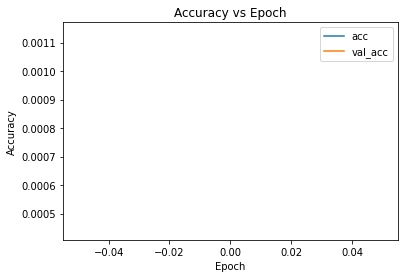

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy vs Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['acc', 'Val_acc'])
plt.show()

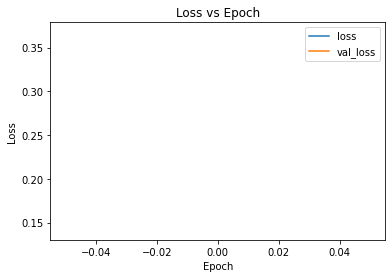

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['loss', 'val_loss'])
plt.show()